Data from https://github.com/pangeo-data/WeatherBench/blob/master/README.md

see https://github.com/pangeo-data/WeatherBench/blob/master/notebooks/3-cnn-example.ipynb

In [27]:
import lasio
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
import torch
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pickle
from collections import OrderedDict

In [77]:
data_in = Path('../../data/raw/weatherbench/')
data_out = Path('../../data/processed/weatherbench/')

# Load data

In [30]:
def load_test_data(path, var, years=slice('2017', '2018')):
    """
    Load the test dataset. If z return z500, if t return t850.
    Args:
        path: Path to nc files
        var: variable. Geopotential = 'z', Temperature = 't'
        years: slice for time window
    Returns:
        dataset: Concatenated dataset for 2017 and 2018
    """
    ds = xr.open_mfdataset(f'{path}/*.nc', combine='by_coords')[var]
    if var in ['z', 't']:
        try:
            ds = ds.sel(level=500 if var == 'z' else 850).drop('level')
        except ValueError:
            ds = ds.drop('level')
    return ds.sel(time=years)

# 3D

In [49]:
class WorldBench3D(torch.utils.data.Dataset):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [124]:
DATADIR = '../../data/processed/weatherbench/5.625deg'

# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}/geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}/temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

z = xr.open_mfdataset(f'{DATADIR}/geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}/temperature_850/*.nc', combine='by_coords').drop('level')

# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]
ds = xr.merge(datasets)

# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('2015', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))
ds


<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 43824)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(17520, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [125]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})

bs=32
lead_time=6
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = WorldBench3D(
    ds_train.sel(time=slice('2015', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = WorldBench3D(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)


print(dg_train.mean, dg_train.std)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = WorldBench3D(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)
x, y = dg_test[0]
print(x.shape, y.shape)

ds

Loading data into RAM
Loading data into RAM
<xarray.DataArray 'z' (level: 2)>
array([54124.863,   274.798], dtype=float32)
Coordinates:
  * level    (level) int64 500 500 <xarray.DataArray 'z' (level: 2)>
array([1110.2052   ,    5.6419535], dtype=float32)
Coordinates:
  * level    (level) int64 500 500
Loading data into RAM
(32, 32, 64, 2) (32, 32, 64, 2)


<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 43824)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
    level    int32 500
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(17520, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

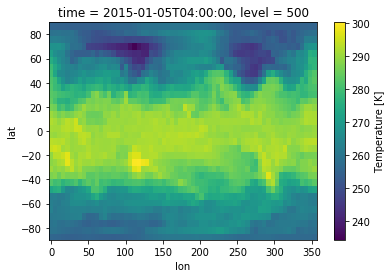

In [126]:
ds_train.isel(time=100)['t'].plot()

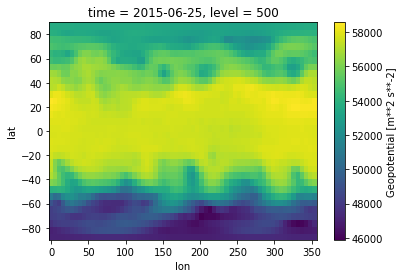

In [129]:
ds_train.isel(time=4200)['z'].plot()

# process 1d

In [79]:
# Make smaller 1d ds
DATADIR = data_in/'5.625deg'

# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}/geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}/temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid]).isel()


z = xr.open_mfdataset(f'{DATADIR}/geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}/temperature_850/*.nc', combine='by_coords').drop('level')

# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]

# Choose grid cell Inland of Perth 31.9505° S, 115.8605° E
# https://www.google.com/maps/@-31.9784233,118.1256945,10.25z
ds_perth = xr.merge(datasets).sel(lat=-30.9375, lon=118.125)

# In this notebook let's only load a subset of the training data
ds_train_perth = ds_perth#.sel(time=slice('2015', '2016'))  
ds_test_perth = ds_perth#.sel(time=slice('2017', '2018'))
ds_perth


data_out.mkdir(exist_ok=True)
ds_perth.to_netcdf(data_out/'perth_5.625deg_z_t.nc')
data_out/'perth_5.625deg_z_t.nc'

PosixPath('../../data/processed/weatherbench/perth_5.625deg_z_t.nc')

In [104]:
# load 1d

In [95]:
class WorldBench1D(torch.utils.data.Dataset):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'level')
        self.mean = self.data.mean(('time')).compute() if mean is None else mean
        self.std = self.data.std('time').compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [105]:
DATADIR = data_out/'5.625deg'

ds_perth = xr.open_dataset('../../data/processed/weatherbench/perth_5.625deg_z_t.nc').drop(['lon', 'lat'])
# In this notebook let's only load a subset of the training data
ds_train_perth = ds_perth.sel(time=slice('1900', '2016'))  
ds_test_perth = ds_perth.sel(time=slice('2017', '2018'))

# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})

bs=32
lead_time=6
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = WorldBench1D(
    ds_train_perth.sel(time=slice('1900', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = WorldBench1D(
    ds_train_perth.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)


print(dg_train.mean, dg_train.std)

# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = WorldBench1D(ds_test_perth, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)
x, y = dg_test[0]
print(x.shape, y.shape)

ds_perth

Loading data into RAM
Loading data into RAM
<xarray.DataArray 'z' (level: 2)>
array([56457.01   ,   284.57483], dtype=float32)
Coordinates:
  * level    (level) int64 500 500 <xarray.DataArray 'z' (level: 2)>
array([820.21606 ,   6.512574], dtype=float32)
Coordinates:
  * level    (level) int64 500 500
Loading data into RAM
(32, 2) (32, 2)


<xarray.Dataset>
Dimensions:  (time: 350640)
Coordinates:
    level    int32 ...
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time) float32 ...
    t        (time) float32 ...

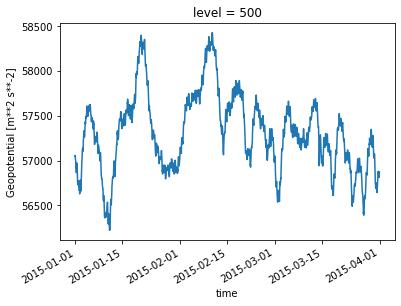

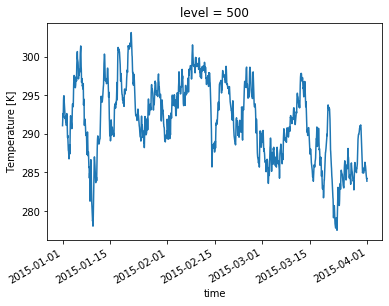

In [132]:
ds_perth.sel(time=slice('2015','2015-03'))['z'].plot()
plt.show()
ds_perth.sel(time=slice('2015','2015-03'))['t'].plot()